In [1]:
import os
import re
import json
import matplotlib.pyplot as plt
import numpy as np
import string
import pandas as pd
import pyspark.sql.functions as F
import nltk
import cPickle as pickle

from os import listdir
from os.path import isfile, join
from scipy.sparse import csr_matrix, dok_matrix, csc_matrix, coo_matrix
import scipy.sparse.linalg
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from itertools import chain
from scipy.sparse import coo_matrix
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry, IndexedRow, IndexedRowMatrix
from pyspark.sql import Row
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifierCV
from operator import add
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division
from pyspark.sql.functions import mean, stddev
%matplotlib inline

In [2]:
# Local Spark
# spark session is now the entry point of spark program
# for line 8, can use local[n] for run spark locally with n cores

runLocal = True
if runLocal == True:
    spark = SparkSession.builder \
        .master('local[10]') \
        .appName("Word Count") \
        .config("spark.driver.maxResultSize", "15g")\
        .getOrCreate()
else:
    #p = subprocess.Popen(['sinteractive', '--partition=broadwl', '--cpus-per-task=10', '--time=00:30:00'], stdout=subprocess.PIPE, shell = True)
    #print(p.stdout.read())
    # start spark master program on this machine and register worker nodes
    os.system('start-spark-slurm.sh&') # use & to put it into background
    # get ip address of this machine
    ip = os.popen('hostname -i').read().strip('\n')
    # change 'local' to be ip of master node
    spark = SparkSession.builder \
        .master('spark://' + ip + ':7077') \
        .appName('Word Count') \
        .config("spark.driver.maxResultSize", "32g")\
        .getOrCreate()
    print('Spark Session web UI: http://{}:4040'.format(ip))

In [5]:
wiki_file = open('/project/cmsc25025/wikipedia/wiki-text.txt','r').readlines()[0]
wiki_file = wiki_file[:len(wiki_file) // 10]
num_chunks = 512
chunks, chunk_size = len(wiki_file), int(len(wiki_file)/num_chunks)
wiki_chunks = [wiki_file[i:i+chunk_size] for i in range(0, chunks, chunk_size)]
wiki_data = spark.sparkContext.parallelize(wiki_chunks)

# Get vocab

In [6]:
regenVocab = False

def trans(t):
    return t.lower().encode('utf-8').translate(string.maketrans("",""), string.punctuation).strip().split()

def tokenizeStr(text, stopwordLst = None):
    
    sents = nltk.sent_tokenize(text)
    tl = [nltk.word_tokenize(s) for s in sents]
    tokenLst = list(chain(*tl))
    
    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())
   
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
            
    return list(workingIter)

def getCounts(wikiTokens):
    a = np.zeros(vocab_dim, dtype=np.int32)
    for token in wikiTokens:
        a[vocabDict[token]] += 1
    return a

In [7]:
if regenVocab:
    #initialize stop words
    stop_words_nltk = nltk.corpus.stopwords.words('english')
    words = wiki_data.flatMap(lambda x: trans(x)).collect()
    word_dict = nltk.FreqDist(words)
    for key in word_dict.keys():
        if word_dict[key] <= 500:
            word_dict.pop(key, None)
    #len(word_dict): 13343
    vocab = sorted(word_dict.keys())
    
    with open("vocab.txt", "w") as v_file:
        for item in vocab:
            v_file.write(item + ", ")
    with open("wiki.txt", "w") as text_file:
         for item in wiki:
            text_file.write(item + ", ")
else:
    with open("vocab.txt") as v_file:
        vocab = v_file.readline().split(', ')

In [8]:
vocab_dim = len(vocab)
vocabDict = {s : i for i, s in enumerate(vocab)}
#tokenize and drop non-vocab
wikiRDD = wiki_data.map(lambda x : [s for s in trans(x) if s in vocab]).cache()

In [9]:
def counter(tokens):
    counts = {}
    for t in tokens:
        try:
            counts[t] += 1
        except KeyError:
            counts[t] = 1
    return counts

def mergeCounts(c1, c2):
    for t, c in c2.items():
        try:
            c1[t] += c
        except KeyError:
            c1[t] = c
    return c1

In [10]:
#This takes a while because we are doing the tokenizing as well
wikiCountsDict = wikiRDD.map(counter).reduce(mergeCounts)
wikiCounts = np.zeros(vocab_dim)
for s, i in vocabDict.items():
    try:
        wikiCounts[i] += wikiCountsDict[s]
    except KeyError:
        #There's a newline added when the file is read from disk
        pass
absD = np.sum(wikiCounts)

Splitting the string into tokens as shown in the notes causes spark to raise an out of memory error, this is the main impedement. Contructiong the cooc matrix goes qucikly once the tokenizing and dropping have happened.

# PMI Embeddings

In [11]:
def makeCooc(wikiTokens):
    coocDict = {}#dok_matrix((vocab_dim, vocab_dim), dtype=np.float64)
    text_len = len(wikiTokens)
    for i, word in enumerate(wikiTokens):
        print(i)
        wordIndex = vocabDict[word]
        if i < 5:
            context = wikiTokens[:i+5]
        elif i > text_len - 5:
            context = wikiTokens[i-5:]
        else:
            context = wikiTokens[i-5:i+5]
        for wordC in [c for c in context if c != word]:
            elemTuple = (wordIndex , vocabDict[wordC])
            try:
                coocDict[elemTuple] += 1
            except KeyError:
                coocDict[elemTuple] = 1
    return coocDict

In [13]:
coocMat = wikiRDD.map(makeCooc).reduce(mergeCounts)

In [14]:
l = len(coocMat)
M = dok_matrix((vocab_dim, vocab_dim), dtype=np.float64)
for i, ((x, y), c) in enumerate(coocMat.items()):
    if i % 1000 == 0:
        print('{:.2f}'.format(i /l * 100), end= '\r')
    M[x, y] = (c + 1) * absD / wikiCounts[x] / wikiCounts[y]
M += M.T

(b) Factorize M to obtain word embeddings

In [15]:
U, s, V = scipy.sparse.linalg.svds(M.tocsr(), k=50)

In [16]:
W = U * np.sqrt(s)

In [17]:
pmi_vects = {w : W[i] for w,i in vocabDict.items()}
pmi_vectsRDD = spark.sparkContext.parallelize(pmi_vects.items()).cache()

# Glove

In [3]:
#pretrained 
p_vectors_file = 'glove.6B.50d.txt'

with open(p_vectors_file, 'r') as f:
    p_vectors = {}
    for line in f:
        try:
            vals = line.rstrip().split(' ')
            p_vectors[vals[0]] = [float(x) for x in vals[1:]]
        except ValueError:
            continue
p_vectsRDD = spark.sparkContext.parallelize(p_vectors.items()).cache()

# Experiments

- the PMI embeddings
- the local GloVe embeddings
- the downloaded pretrained GloVe embeddings

## (a) Read your local GloVe embeddings

In [4]:
vocab_file   = 'GloVe/wiki-vocab.txt'
vectors_file = 'GloVe/wiki-vectors.txt'

with open(vocab_file, 'r') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]

with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]
        
vocabulary  = {w: idx for idx, w in enumerate(words)}
ivocabulary = {idx: w for idx, w in enumerate(words)}

vectsRDD = spark.sparkContext.parallelize(vectors.items()).cache()

## (b) For each of the following words, find the 5 closest words in the embedding space: 
physics, republican, einstein, algebra, fish. 

Report and comment on your results and the differences between the three sets of embeddings.

In [5]:
def find_closest(v, n, label):
    if label == 'local':
        vect = vectors
        RDD = vectsRDD
    elif label == "pre":
        vect = p_vectors
        RDD = p_vectsRDD
    elif label == 'pmi':
        vect = pmi_vects
        RDD = pmi_vectsRDD
    
    if type(v)== type(' '):
        v = np.array(vect[v])
        
    rdd = RDD.map(lambda x: (x[0], mean_squared_error(v,np.array(x[1]))))
    tuples = sorted(rdd.collect(), key=lambda x: x[1])[1:1+n]
    words = [x[0] for x in tuples]
    return words

In [21]:
word_list = ['physics', 'republican', 'einstein', 'algebra', 'fish']
print("Results from pretrained PMI embeddings:")
for word in word_list:
    print(word, ": ", ', '.join(find_closest(word,5, 'pmi')), sep = '')
print()
print("Results from local GloVe embeddings:")
for word in word_list:
    print(word, ": ", ', '.join(find_closest(word,5, 'local')), sep = '')
print()
print("Results from pretrained GloVe embeddings:")
for word in word_list:
    print(word, ": ", ', '.join(find_closest(word,5, 'pre')), sep = '')

Results from pretrained PMI embeddings:
physics: answers, predicted, symmetry, fields, reflects
republican: rugby, yeltsin, blessed, leading, gore
einstein: mountainous, challenge, archbishop, requested, commissioners
algebra: mathematics, agree, lorentz, given, covenant
fish: fruit, freshwater, whales, liver, coffee

Results from local GloVe embeddings:
physics: mechanics, mathematics, chemistry, quantum, theoretical
republican: democrat, senator, representative, republicans, whig
einstein: relativity, maxwell, formulated, bose, relates
algebra: algebras, algebraic, finite, multiplication, boolean
fish: feed, fresh, wild, bird, dogs

Results from pretrained GloVe embeddings:
physics: chemistry, mathematics, theoretical, science, biology
republican: gop, democrat, democratic, republicans, democrats
einstein: bohr, relativity, invented, freud, gottlieb
algebra: geometry, homological, algebraic, associative, analytic
fish: salmon, shrimp, meat, bird, wild


## (c) france :  paris ::  england :  ?

In [6]:
def get_analogy(a,b,c,local, mute = False, pmi = False):
    if local == True:
        v = np.array(vectors[b])-np.array(vectors[a])+np.array(vectors[c])
        print("Result from local GloVe embeddings:", find_closest(v,1,'local')[0])
    if pmi:
        v = np.array(pmi_vects[b])-np.array(pmi_vects[a])+np.array(pmi_vects[c])
        print("Result from PMI embeddings:", find_closest(v,1,'pmi')[0])
    p_v = np.array(p_vectors[b])-np.array(p_vectors[a])+np.array(p_vectors[c])
    s = find_closest(p_v,1,"pre")[0]
    if not mute:
        print("Result from pretrained GloVe embeddings:", s)
    else:
        return s

In [23]:
get_analogy('france','paris','england', True, pmi = True)

Result from local GloVe embeddings: edinburgh
Result from PMI embeddings: seat
Result from pretrained GloVe embeddings: london


## (d) Analogies

In [11]:
path = '/project/cmsc25025/assn4_analogy'
files = [f for f in listdir(path) if isfile(join(path, f))]
def rmv(t):
    words = filter(lambda x: x!= "", re.split('[^a-zA-Z]', t))
    return words[:3]

In [15]:
files[15]

u'aham-jdhanoa.txt'

In [24]:
for fname in files:
    print("Looking at analogies from {}".format(fname))
    with open(path+"/"+fname, 'r') as f:
        for line in f:
            try:
                a, b, c = rmv(line)
                print('{} : {} = {} : '.format(a, b, c), end = '')
            except ValueError:
                print("Something is wrong with line: '{}'".format(line))
            else:
                try:
                    print(get_analogy(a,b,c, False, True))
                except KeyError as e:
                    print("'{}' missing from library".format(e.args[0]))
    print()

Looking at analogies from jihongsong-zlin7.txt
segregate : unify = damage : overcome
argentina : brazil = iran : tehran
ashes : urn = money : paying
telephone : cord = television : spinal
walk : roam = speak : resent
novel : epilogue = meal : meal
chinese : china = french : french
evening : morning = dinner : lunch
left : right = horizontal : vertical
theorem : deduce = hypothesis : decipher

Looking at analogies from casperneo-rjcai.txt
h : water = bird : fish
chicken : egg = cow : cloned
go : green = stop : yellow
chicago : illinois = dallas : illinois
library : book = resturant : 'resturant' missing from library
dessert : meal = revelations : abuse
chef : knife = student : gun
cookies : milk = chips : chips

Looking at analogies from guozhenj.txt
math : physics = calculus : relativity
marvel : dc = captain : adrian
thor : loki = hammer : shove
odin : hela = asgard : stroma
beijing : shanghai = tiananmen : pagoda
detroit : chicago = car : driving
earth : mars = human : cites
ice : fi

## (e) Visualize only the pretrained GloVe embeddings in two dimensions

In [25]:
words_ = p_vectors.keys()
W = p_vectsRDD.map(lambda x: np.array(x[1])).collect()

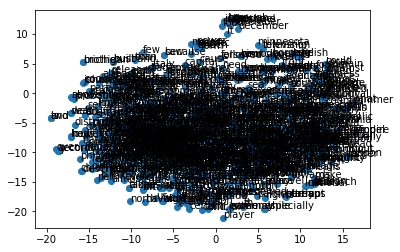

In [26]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(W[:1000])
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0),textcoords='offset points')
plt.show()

In this tiny segment of words, we are able to observe that words that surround "parliament" include "go", "territory", "different", "future", "notable", "public", "problem", "independence", "minister" and etc. It's apparent that these words are often used close to "parliament". For example, "go to parliament", "the parliament discuss territory problems", "different parliament could lead to different future".

In [ ]:
spark.stop()